In [16]:
import numpy as np
import matplotlib.pyplot as plt
from quimb import *
from scipy import sparse
from quimb.linalg.base_linalg import *
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.linalg import expm
from qiskit.quantum_info import Operator, random_pauli
from qiskit.extensions import UnitaryGate

In [17]:
N = 8 #Number of qubits
J = np.zeros((N,N))
for i in range(N-1):
    J[i,i+1] = np.random.normal(loc=0.75,scale = 0.25,size=None)
print(J)

I, X, Y, Z = (pauli(s) for s in 'IXYZ')

def dis_ising(J,N):
    M = 2**N # DImension of hilbert space
    H = np.zeros((M,M))
    for i in range(N-1):
        H = H + J[i,i+1]*ikron(Z,dims = [2]*N,inds = [i,i+1])
    return H

H = dis_ising(J, N)
# U = expm(H*dt)

gs = groundstate(H)
# print(gs)
# test_state = kron(up(), down(), up(), up())
# print(expec(test_state, H))

m = np.zeros((N))
for i in range(N):
    rho_red = ptr(gs,dims = [2]*N, keep = i)
    m[i] = expec(Z,rho_red)
print(m)


analytical_groundstate_energy = expec(H,gs)
print("Lowest energy from exact Diagonalisation is = ", analytical_groundstate_energy)

[[0.         0.72447269 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.86000674 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         1.12997739 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.55719538 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.81655576
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.61929484 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.7965723 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
[-0.51544867  0.51544867 -0.51544867  0.51544867 -0.51544867  0.51544867
 -0.51544867  0.51544867]
Lowest energy from exact Diagonalisation is =  -5.5040750962428255


In [66]:
def scaling(x):
    if x <= 0.5:
        y = 0.5 * np.sin(np.pi * x)
    elif x > 0.5:
        y = 1 - 0.5 * np.sin(np.pi * x)
    # y = (x-0.5)**3+1/2
    return y


def a(t):
    a = scaling(t)
    return a
def b(t):
    b = 1 - scaling(t)
    return b


def single_q_error(qc,p1,i):
    draw = np.random.uniform(0.0,1.0)
    pauli_error = UnitaryGate(random_pauli(1))
    if draw<p1:
        return qc.append(pauli_error,[i])
def two_q_error(qc,p2,i,j):
    draw = np.random.uniform(0.0,1.0)
    pauli_error = UnitaryGate(random_pauli(1))
    qubit_location = np.random.choice([i,j])
    if draw<p2:
        return qc.append(pauli_error,[qubit_location])

def GSA_approx(T, L, J, p1,p2):
    #p1: Single qubit gate error 
    #p2: 2 qubit gate error
    dt = T/L                    # time step
    qc = QuantumCircuit(N)
    for qubit in range(0, N):  # creating uniform superposition
        single_q_error(qc,p1,qubit)
        qc.h(qubit)
        single_q_error(qc,p1,qubit)
    for k in range(L):
        for i in range(N-2, -1, -2): #even bonds
            j = i+1
            two_q_error(qc,p2,i,j)
            qc.rzz(-0.1* a(k/L) * J[i, j] * dt, j, i)
            two_q_error(qc,p2,i,j)
        for i in range(0, N, 2): #even bonds      # H_D = uniform X field as the Driver Hamiltonian
            single_q_error(qc,p1,i)
            qc.rx(0.1 * b(k/L) * dt, i)
            single_q_error(qc,p1,i)
        for i in range(N-3, -1, -2): #odd bonds
            j = i+1
            two_q_error(qc,p2,i,j)
            qc.rzz(-0.1 * a(k/L) * J[i, j] * dt, j, i)
            two_q_error(qc,p2,i,j)
        for i in range(1, N-1, 2): #odd bonds      # H_D = uniform X field as the Driver Hamiltonian
            single_q_error(qc,p1,i)
            qc.rx(0.1 * b(k/L) * dt, i)
            single_q_error(qc,p1,i)
    qc.measure_all()
    return qc

def measure_circuit(qc):
    num_shots_per_point = 10
    sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, sim)
    counts = sim.run(t_qc, shots=num_shots_per_point).result().get_counts()
    expectation_z = 0
    for key in counts:
        bitstring = key
        for m in range(N-1, 0, -1):
            expectation_z += J[N-m-1, N-m]*(int(counts[key]) * (-1) ** (int(bitstring[m-1]) + int(bitstring[m])))
    expectation_z = expectation_z / num_shots_per_point
    return expectation_z





In [83]:
T = 100*np.pi       #final time
L = 16
#print(GSA_approx(T,L,J,1.0,1.0))
print(measure_circuit(GSA_approx(T,L,J,p1,p2)))

-5.220634672779761


In [69]:
#T = 100*np.pi
L= 15
num_points = 1
Tlist =np.linspace(60*np.pi,150*np.pi,num_points) 
#Llist = np.linspace(10,200,num_points,dtype=int)
approx = np.zeros((num_points))
p1 = 0.0005
p2 = 0.005
for i in range(num_points):
    #print(i)
    #approx[i]=np.abs(np.abs(analytical_groundstate_energy)-np.abs(measure_circuit(GSA_approx(T,Llist[i],J))))
    #print(measure_circuit(GSA_approx(Tlist[i],L,J)))
    noisy_measurement = [measure_circuit(GSA_approx(Tlist[i],L,J,p1,p2)) for k in range(100)]
    print(noisy_measurement)
    #approx[i]=np.abs(np.abs(analytical_groundstate_energy)-np.abs())
print("completed")

[-3.1991621906733316, -5.123882515259277, -5.000023546537205, -5.012443440196441, -4.474293084197094, -4.994026826025931, -2.7458682617669377, -4.219567114995356, -2.6280805357698895, -4.445285185061126, -3.09983055126869, -4.299631835963326, -2.997292099154972, -4.643675478291264, -4.972916735335615, -4.493704972948467, -3.2531483892107405, -3.5713515635510618, -4.83444537128494, -4.774028068262252, -5.012443440196442, -5.268777052457915, -2.816390127805625, -1.760028068797228, -4.656362366470805, -5.006446719685168, -4.275902790966953, -2.0235943916353127, -2.991506420236205, -1.3795951983943537, -4.67451198612101, -3.062568307482084, -2.6281512312460182, -3.246918394904964, -3.1305530644627875, -5.22932486981084, -3.168739120784177, -3.847566357199665, -2.379326867864743, -4.305554034260849, -4.876164577815131, -2.2774613082893156, -5.084355810398454, -5.28119694611715, -4.773883097947548, -5.136302408918513, -2.7704752995886914, -3.0842196120146914, -3.0397047528421597, -5.16007239

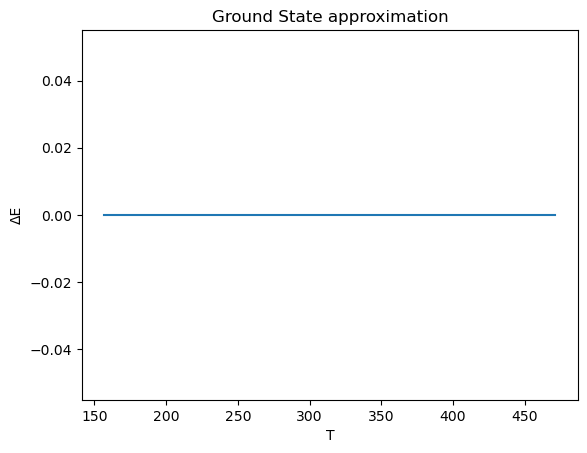

In [65]:
plt.plot(Tlist,approx)
#plt.xlabel('L')
plt.xlabel('T')
plt.ylabel('ΔE')
plt.title("Ground State approximation")
#plt.savefig("Groundstateapprox_vs_T(L=15).pdf")
#plt.savefig("Groundstateapprox_vs_L(fixed T).pdf")
plt.show()